In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import pickle as pkl
from collections.abc import MutableMapping
import time
from typing import Any, Callable, Iterable, Mapping, Optional, Union
import json

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import tqdm
from IPython.display import HTML

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import jax
from jax import vmap, lax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import flax
from flax import linen as nn
import optax
from frozendict import frozendict

import jraph
from jraph._src import graph as gn_graph
from jraph._src import utils

print(f'Jax: CPUs={jax.local_device_count("cpu")} - GPUs={jax.local_device_count("gpu")}')

Jax: CPUs=1 - GPUs=1


In [3]:
from hgnn.noisify import add_noise_and_truncate
from hgnn.model import *
from hgnn.hamiltonian import *
from hgnn.training import *
from hgnn.simulating import *

In [4]:
prefix = 'nbody-n4'
noise_scale = 0.
truncate_decimal = 4
train_length = 25
batch_size = 20

lr = 0.1

Zs_train = jnp.load(f'./data/{prefix}/Zs_train.npy')
Zs_dot_train = jnp.load(f'./data/{prefix}/Zs_dot_train.npy')
Zs_test = jnp.load(f'./data/{prefix}/Zs_test.npy')
Zs_dot_test = jnp.load(f'./data/{prefix}/Zs_dot_test.npy')

Zs_train, Zs_dot_train = add_noise_and_truncate(Zs_train, Zs_dot_train, 
                                                scale=noise_scale, 
                                                decimals=truncate_decimal)
# Zs_test, Zs_dot_test = add_noise_and_truncate(Zs_test, Zs_dot_test, scale=0.05, decimals=1)

N2, dim = Zs_train.shape[-2:]
N = N2 // 2
species = jnp.zeros(N, dtype=int)
masses = jnp.ones(N)

Zs = Zs_train.reshape(-1, train_length, N2, dim)
Zs_dot = Zs_dot_train.reshape(-1, train_length, N2, dim)

Zst = Zs_test.reshape(-1, train_length, N2, dim)
Zst_dot = Zs_dot_test.reshape(-1, train_length, N2, dim)

print('N2:', N2)
print('dim:', dim)
print('Zs.shape:', Zs.shape)
print('Zs_dot.shape:', Zs_dot.shape)
print('Zst.shape:', Zst.shape)
print('Zst_dot.shape:', Zst_dot.shape)
print('Zs_test.shape:', Zs_test.shape)
print()

with open(f'./data/{prefix}/param.json', 'r') as f:
    d = json.load(f)
    stride = d['stride']
    dt = d['dt']
#     lr = d['lr']
#     batch_size = d['batch_size']
    epochs = d['epochs']
    
print('stride:', stride)
print('dt:', dt)
print('lr:', lr)
print('batch_size:', batch_size)
print('epochs:', epochs)

N2: 8
dim: 3
Zs.shape: (300, 25, 8, 3)
Zs_dot.shape: (300, 25, 8, 3)
Zst.shape: (100, 25, 8, 3)
Zst_dot.shape: (100, 25, 8, 3)
Zs_test.shape: (5, 500, 8, 3)

stride: 100
dt: 0.001
lr: 0.1
batch_size: 20
epochs: 2000


In [5]:
def get_fully_connected_senders_and_receivers(num_particles: int, self_edges: bool = False):
    """Returns senders and receivers for fully connected particles."""
    particle_indices = np.arange(num_particles)
    senders, receivers = np.meshgrid(particle_indices, particle_indices)
    senders, receivers = senders.flatten(), receivers.flatten()
    if not self_edges:
        mask = senders != receivers
        senders, receivers = senders[mask], receivers[mask]
    return senders, receivers

def get_fully_edge_order(N):
    out = []
    for j in range(N):
        for i in range(N):
            if i == j:
                pass
            else:
                if j > i:
                    out += [i*(N-1) + j-1]
                else:
                    out += [i*(N-1) + j]
    return np.array(out)

senders, receivers = get_fully_connected_senders_and_receivers(N)
eorder = get_fully_edge_order(N)

In [6]:
key = jax.random.PRNGKey(42)

Ef = 1  # eij dim
Oh = 1

Eei = 5
Nei = 5

hidden = 5
nhidden = 2

In [7]:
params = generate_HGNN_params(Oh, Nei, Ef, Eei, dim, hidden, nhidden, key)

In [8]:
R, V = jnp.split(Zs[0, 0], 2, axis=0)

apply_fn = energy_fn(senders=senders, receivers=receivers, species=species, R=R, V=V, eorder=eorder)
Hmodel = generate_Hmodel(apply_fn)

zdot_model, lamda_force_model = get_zdot_lambda(
    N, dim, hamiltonian=Hmodel, drag=None, 
    constraints=None, 
    external_force=None)


v_zdot_model = vmap(zdot_model, in_axes=(0, 0, None))

In [14]:
factor = 50

runs_tr = Zs.shape[1]
stride_tr = stride // factor
dt_tr = dt * factor

sim_model_training = get_forward_sim_noparam(
    zdot_model=zdot_model, 
    runs=runs_tr, stride=stride_tr, dt=dt_tr, tol=1e-4
)


@jax.jit
def loss_fn_indiv(params, R, V):
    z_pred_out = sim_model_training(R[0], V[0], params)
    r_pred_out = z_pred_out[:, :N]
    v_pred_out = z_pred_out[:, N:]
    return jnp.mean((r_pred_out - R) ** 2) + jnp.mean((v_pred_out - V) ** 2)
#     V_approx = jnp.gradient(R, axis=0) / (dt * stride)
#     return jnp.mean((r_pred_out - R) ** 2) + jnp.mean((v_pred_out - V_approx) ** 2)


@jax.jit
def loss_fn(params, Rs, Vs):
    loss_ = vmap(loss_fn_indiv, in_axes=(None, 0, 0))(params, Rs, Vs)
    return jnp.mean(loss_)

In [15]:
gloss = generate_gloss(loss_fn=loss_fn)

opt_init, opt_update_, get_params = optimizers.adam(lr)

opt_update = generate_opt_update_wrapper(opt_update_=opt_update_)

step = generate_update_fn(gloss=gloss, opt_update=opt_update, get_params=get_params)

Rs, Vs = jnp.split(Zs, 2, axis=2)
Rst, Vst = jnp.split(Zst, 2, axis=2)

bRs, bVs, bZs_dot = batching(Rs, Vs, Zs_dot, size=min(len(Rs), batch_size))

In [ ]:
print(f"Training ...")

# opt_state = optimiser.init(params)
opt_state = opt_init(params)

epochs = 100

epoch = 0
optimizer_step = -1
larray = []
ltarray = []

batches = list(zip(bRs, bVs))
pbar = tqdm.tqdm_notebook(total=epochs * len(batches))

# for epoch in tqdm.tnrange(epochs):

for epoch in range(epochs):
    
    l = 0.0
    for data in batches:
        change_RNG()
        optimizer_step += 1
        opt_state, params, l_ = step(optimizer_step, (opt_state, params, 0), *data)
        l += l_
        pbar.update()
    l = l / len(bRs)
    larray += [l]
    ltarray += [loss_fn(params, Rst, Vst)]
    print(f"Epoch: {epoch + 1}/{epochs} Loss (MSE):  train={larray[-1]}, test={ltarray[-1]}")
    
params = get_params(opt_state)

Training ...


/tmp/ipykernel_2197856/1470872755.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm.tqdm_notebook(total=epochs * len(batches))


  0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
fig, axs = plt.subplots(1, 1)
plt.semilogy(larray, label="Training")
plt.semilogy(ltarray, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

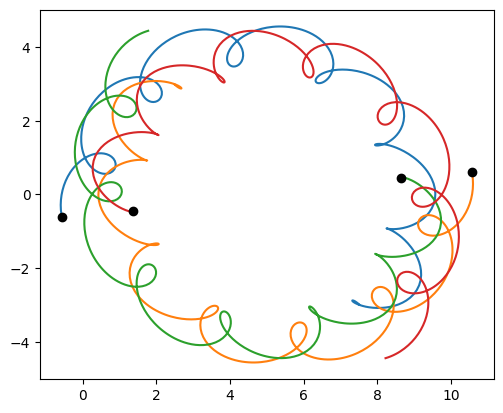

In [262]:
idx = 4
reps = 100

i_err = 1

z_actual_out = Zs_test[idx]
x_act_out, _ = jnp.split(z_actual_out, 2, axis=1)

for i in range(x_act_out.shape[1]):
    plt.plot(x_act_out[:,i,0], x_act_out[:,i,1], '-', color=f'C{i}')
plt.plot(x_act_out[-1,:,0], x_act_out[-1,:,1], 'o', color='black')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [263]:
runs = Zs_test.shape[1]

sim_model = get_forward_sim(params=params, zdot_model=zdot_model, 
                            runs=runs, stride=stride, dt=dt, tol=1e-5)


z_actual_out = Zs_test[idx]
x_act_out, p_act_out = jnp.split(z_actual_out, 2, axis=1)

Zs_init = Zs_test[idx:idx+1, 0:1]
    
trajectories = {
    'pred_pos': [],
    'pred_vel': [],
    'actual_pos': x_act_out,
    'actual_vel': p_act_out,
}

for _ in tqdm.tnrange(reps):
    
    change_RNG()
    
    Zs_noisy = add_noise_and_truncate(Zs_init, Zs_init, scale=noise_scale)[0].squeeze((0, 1))
    R_noisy = Zs_noisy[:N]
    V_noisy = Zs_noisy[N:]

    z_pred_out = sim_model(R_noisy, V_noisy)
    x_pred_out, p_pred_out = jnp.split(z_pred_out, 2, axis=1)

    with jax.default_device(jax.devices('cpu')[0]):
        trajectories['pred_pos'].append(x_pred_out)
        trajectories['pred_vel'].append(p_pred_out)

/tmp/ipykernel_3806931/543477224.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tqdm.tnrange(reps):


  0%|          | 0/100 [00:00<?, ?it/s]

In [264]:
trajectories['pred_pos'] = jnp.array(trajectories['pred_pos'])
trajectories['pred_vel'] = jnp.array(trajectories['pred_vel'])

trajectories['pred_pos_avg'] = jnp.mean(trajectories['pred_pos'], axis=0)
trajectories['pred_vel_avg'] = jnp.mean(trajectories['pred_vel'], axis=0)

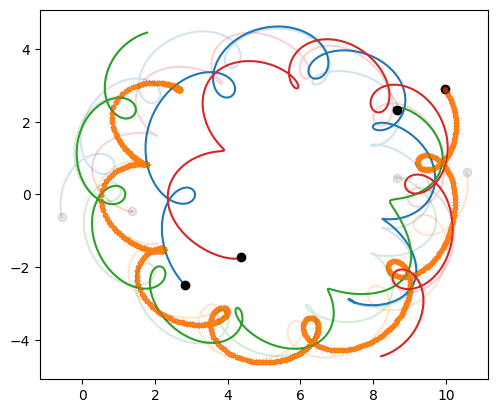

In [265]:
i_err = 1

r = trajectories['actual_pos']
for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.2)
plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.1)

r = trajectories['pred_pos_avg']
for i in range(r.shape[1]):
    if i != i_err:
        plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}')
plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black')

r = trajectories['pred_pos']
for t in range(r.shape[1]):
    plt.plot(r[:,t,i_err,0], r[:,t,i_err,1], '.', color=f'C{i_err}', markerfacecolor=None, alpha=1. / reps)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [102]:
fig, ax = plt.subplots()

# r = trajectories['actual_pos']
# traj_actual = [ax.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.1)[0] for i in range(r.shape[1])]  
# ball_actual, = ax.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.1)

r = trajectories['pred_pos_avg']
traj_pred = [ax.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=1.)[0] for i in range(r.shape[1])]  
ball_pred, = ax.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.5, zorder=5.)

r = trajectories['pred_pos']
point_cloud = [ax.plot(r[:,0,i,0], r[:,0,i,1], 'o', color=f'C{i}', 
                       alpha=2. / reps, zorder=4., markerfacecolor=None)[0] 
               for i in range(r.shape[2])]  

def gather():
#     return traj_actual + [ball_actual] + traj_pred + [ball_pred]
    return point_cloud + traj_pred + [ball_pred]

def init():
    ax.set_aspect('equal', adjustable='box')
    return gather()

def update(frame):
    
#     r = trajectories['actual_pos']
#     for i in range(r.shape[1]):
#         traj_actual[i].set_data(r[:frame,i,0], r[:frame,i,1])
#     ball_actual.set_data(r[frame,:,0], r[frame,:,1])

    r = trajectories['pred_pos_avg']
    for i in range(r.shape[1]):
        traj_pred[i].set_data([], [])
    ball_pred.set_data(r[frame,:,0], r[frame,:,1])
    
    r = trajectories['pred_pos']
    for i in range(r.shape[2]):
        point_cloud[i].set_data(r[:,frame,i,0], r[:,frame,i,1])
    
    return gather()

ani = FuncAnimation(fig, update, frames=tqdm.tnrange(runs), init_func=init, blit=True, interval=10)
plt.close(fig)
HTML(ani.to_jshtml())

/tmp/ipykernel_3534820/1590745960.py:42: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  ani = FuncAnimation(fig, update, frames=tqdm.tnrange(runs), init_func=init, blit=True, interval=10)


  0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
writergif = PillowWriter(fps=30, bitrate=300) 
ani.save(f'./demo/nbody-n3-uncertainty-{idx}.gif', writer=writergif)